In [1]:
include("FastConv/FastConv.jl")
using FastConv
using MAT
using Plots
pyplot()

INFO: Recompiling stale cache file /Users/yizhan/.julia/lib/v0.6/Blosc.ji for module Blosc.
INFO: Recompiling stale cache file /Users/yizhan/.julia/lib/v0.6/MAT.ji for module MAT.
INFO: Recompiling stale cache file /Users/yizhan/.julia/lib/v0.6/Plots.ji for module Plots.
INFO: Recompiling stale cache file /Users/yizhan/.julia/lib/v0.6/VersionParsing.ji for module VersionParsing.
INFO: Recompiling stale cache file /Users/yizhan/.julia/lib/v0.6/PyPlot.ji for module PyPlot.


Plots.PyPlotBackend()

In [2]:
"""
    EEGAnalysisContainer

store all the raw data and epoch data in one place.
"""
struct EEGAnalysisContainer
    
    # meta
    subject::String  # subject name or id
    expname::String  # experiment name or id
    
    data_dir::String 
    result_dir::String
    
    # recording
    fs::Float32  # sampling frequency
    iti::Float32
    
    # analysis parameters
    roi::Tuple{Float32,Float32}  # region of interest
    
    # data
    channels::Array{Float32, 2}
    tspec::Array{Float32, 1}
    markers::Dict{String, Array{Float32, 1}}
    
    # pre-processed data
#     channel_epoch::Dict{String, Array{Float32, 3}}

end


"""
    create_epoch(channels::Array{T, 2}, markers::Array{T, 1}, roi::Tuple{T, T}, fs::T)

data epoching, according to the marker time points in `markers` and region of interest (`roi`).
"""
function create_epoch(channels::Array{T, 2}, markers::Array{T, 1}, roi::Tuple{T, T}, fs::T) where {T}
    
    epoch = zeros(T, (size(channels, 1), floor((roi[2]-roi[1])*fs), size(markers, 1)))
    L = floor((roi[2]-roi[1])*fs)
    for (midx, mark) in enumerate(markers)
        start = Int(floor((mark+roi[1])*fs))
        epoch[:, :, midx] = channels[:, start:start+L-1]
    end
    return epoch
end


"""
    create_container(datadir, resultdir, patientname, expname)

import data and create an `EEGAnalysisContainer`.
"""
function create_container(datadir, resultdir, patientname, expname)
    rawdata = matread(joinpath(datadir, patientname, 
            "EEG", "Compact", expname*".mat"))
    
    fs = size(rawdata["channels"],2) / rawdata["times"][end] |> floor
    iti = rawdata["markers"]["grating"][1,2] - rawdata["markers"]["grating"][1,1]
    roi = (-2.0, iti)
    
    channels = rawdata["channels"]
    tspec = rawdata["times"][:]
    markers = Dict([k=>rawdata["markers"][k][:] for k in keys(rawdata["markers"])])
    
#     epoch = Dict([k => create_epoch(channels, markers[k], roi, fs) for k in keys(markers)])
    
    return EEGAnalysisContainer(patientname, expname, 
        joinpath(datadir, patientname), joinpath(resultdir, patientname),
        fs, iti, roi, channels, tspec, markers)
end


"""
    get_ERP(container::EEGAnalysisContainer, markername::String)

calculate the ERP from the epoch data in the container.
"""
function get_ERP(container::EEGAnalysisContainer, markername::String)
    container.channel_epoch[markername] |> (x) -> mean(x, 3) |> (x) -> squeeze(x, 3)
end

get_ERP

In [3]:
@time raw = create_container("../../Data", "../../Result", "Chen Zhou", "180903-2-5");

  3.649564 seconds (1.38 M allocations: 414.394 MiB, 10.08% gc time)


In [4]:
using WAV

INFO: Recompiling stale cache file /Users/yizhan/.julia/lib/v0.6/WAV.ji for module WAV.


In [11]:
wavwrite(raw.channels[99,:], "180903-2-5-Ch99.wav", Fs=2000)

In [13]:
y, fs = wavread("180903-2-5-Ch99.wav")

([15.0304; 15.433; … ; -54.9774; -51.9579], 2000.0f0, 0x0020, Dict{Symbol,Any}(Pair{Symbol,Any}(:fmt, WAV.WAVFormat(0xfffe, 0x0001, 0x000007d0, 0x00001f40, 0x0004, 0x0020, WAV.WAVFormatExtension(0x0020, 0x00000000, UInt8[0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x10, 0x00, 0x80, 0x00, 0x00, 0xaa, 0x00, 0x38, 0x9b, 0x71])))))

# wavelet transform

In [114]:
"""
    morlet(F, fs)

return the morlet wavelet of `F` hz in complex array, 
corresponding to sampling rate `fs`.
"""
function morlet(F::T, fs::T) where {T}
    s = 6 / (2 * pi * F)
    wtime = linspace(-1,1,2*fs)
    wavelet = exp.(2*pi*wtime*F*1im) .* exp.(- wtime.^2/(2*s^2))
    return wavelet |> Array{Complex{T}}
end


"""
    dwt(data::Array{T, 1}, F, fs)

perform discrete wavelet transform to data array.
`F` as the wavelet frequency, `fs` as the sampling rate.
"""
function dwt(data::Array{T, 1}, F::T, fs::T) where {T}
    rawdata = data |> fft |> ifft
    result = Array{Complex{T}, 2}(size(data, 1), size(frange, 1))
    wavelet = morlet(F, fs)
    result = conv(rawdata, wavelet)[Int(fs):end-Int(fs)]
    return result
end


"""
    dwt(data::Array{T, 2}, F, fs)

perform discrete wavelet tranform to data matrix.
columns (axis 2) as the observations.
`F` as the wavelet frequency, `fs` as the sampling rate.
"""
function dwt(data::Array{T, 2}, F::T, fs::T) where {T}
    rawdata = data |> fft |> ifft
    result = zeros(Complex{T}, size(data, 1), size(data, 2))
    wavelet = morlet(F, fs)
    
    #TODO: further optimization
    for chidx = 1:size(data, 2)
        result[:, chidx] = conv(rawdata[:, chidx], wavelet)[Int(fs):end-Int(fs)]
    end
    
    return result
end


"""
    power(data::Array{T, 2}, fs, frange; db_calibration)

calculate total power of the data matrix. 
columns (axis 2) as diferent trials of one channel (or observation),
`fs` as sampling frequency, `frange` as the target wavelet frequencies.
`db_calibration` set the calibration methods, one of [`:zscore`, `:none`]
"""
function power(data::Array{T, 2}, fs::T, frange::Array{T, 1}; db_calibration::Symbol=:zscore) where {T}
    result = Array{T, 2}(size(data,1), size(frange, 1))
    for (fidx, ftarget) in enumerate(frange)
        result[:, fidx] = mean(abs.(dwt(data, ftarget, fs)) .^ 2, 2)[:]
    end
    
    if db_calibration == :zscore
        temp = log10.(result)
        result = (temp .- mean(temp, 2)) ./ std(temp, 2)
    else
        result = log10.(result)
    end
    
    return result
end

power

In [89]:
curve = raw.channel_epoch["grating"][15,:,:]
print(size(curve))
frange = logspace(log10(1), log10(80), 30) |> Array{Float32}
@time r = power(curve, raw.fs, frange);

(14000, 20)  1.199320 seconds (77.35 k allocations: 843.282 MiB, 12.27% gc time)


# validation

In [41]:
using WAV

In [48]:
(y, fs, nbits, opt) = wavread("../python/archive/Woodcreeper.wav")

([0.0; 0.0; … ; 0.00021363; 0.000305185], 44100.0f0, 0x0010, Dict{Symbol,Any}(Pair{Symbol,Any}(:fmt, WAV.WAVFormat(0x0001, 0x0001, 0x0000ac44, 0x00015888, 0x0002, 0x0010, WAV.WAVFormatExtension(0x0000, 0x00000000, UInt8[])))))

In [116]:
@time jj = power(y, Float64(fs), logspace(log10(1), log10(15000), 30), db_calibration=:none)

  2.721771 seconds (135.18 k allocations: 1.158 GiB, 13.63% gc time)


141708×30 Array{Float64,2}:
 -2.02819  -2.3377   -3.43749  -4.50875  …  -8.84495  -9.68395  -10.2158 
 -2.06864  -2.3726   -3.48262  -4.53083     -8.68213  -9.47029   -9.80335
 -2.33554  -2.59868  -3.78808  -4.66654     -8.54496  -9.30969   -9.5109 
 -2.94336  -3.09372  -4.55069  -4.91357     -8.43323  -9.19544   -9.33814
 -3.47723  -4.28293  -4.67011  -5.2534      -8.34667  -9.11619   -9.27489
 -2.89801  -4.17041  -4.05611  -5.59457  …  -8.28482  -9.05633   -9.28066
 -2.75086  -3.81031  -3.9248   -5.72923     -8.24695  -9.0008    -9.27125
 -2.93955  -4.29181  -4.09335  -5.56237     -8.23182  -8.9424    -9.20511
 -3.44699  -4.39288  -4.62107  -5.27113     -8.23733  -8.88309   -9.14955
 -3.25104  -3.3609   -4.93546  -5.01801     -8.2602   -8.8272    -9.16821
 -2.78793  -2.96802  -4.34515  -4.85688  …  -8.29563  -8.77534   -9.26442
 -2.62029  -2.83259  -4.13162  -4.79128     -8.33743  -8.72576   -9.36636
 -2.68232  -2.88276  -4.20951  -4.81601     -8.37903  -8.67977   -9.34639
  ⋮       

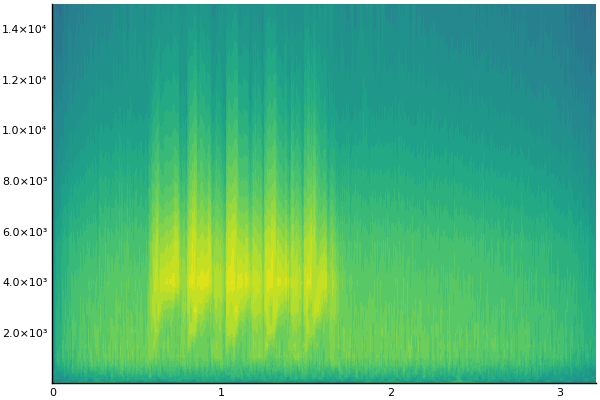

In [117]:
contourf(linspace(0, length(y)/fs, length(y)), logspace(log10(1), log10(15000), 30), jj', color=:viridis, levels=30)
plot!(colorbar=false)

![](../python/archive/woodcreeper.png)